<a href="https://colab.research.google.com/github/SahanaDil/hands-on-ml-2nd-3rd-edition/blob/main/3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)
#70000 images, each image has 784 features. each image is 28 * 28 pixels = 784

(70000, 784)
(70000,)


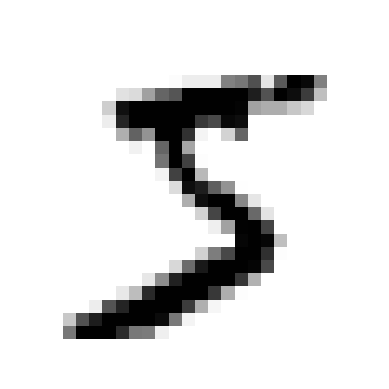

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]
#this is a string, convert y to integer type

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

binary classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) #stochastic means random, random state helps us reproduce our results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit]) #correctly identified a 5

array([ True])

evaluating classifiers

In [11]:
#cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy') #this only has high accuracy because the dataset is skewed, only about 10% of the dataset is 5s.
#this shows that accuracy isn't always the best way to measure a classifier's performance

array([0.91125, 0.90855, 0.90915])

**confusion matrix**  
It's a table that compares predictions to the actual values.

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #it returns predictions from each test fold

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) #(target classes, predicted classes)
#row - actual class, column - predicted class


array([[53892,   687],
       [ 1891,  3530]])

In [15]:
#precision + recall
from sklearn.metrics import precision_score, recall_score
precision_5 = precision_score(y_train_5, y_train_pred)
recall_5 = recall_score(y_train_5, y_train_pred)
print(f'precision: {precision_5}')
print(f'recall:{recall_5}')

precision: 0.8370879772350012
recall:0.6511713705958311


In [16]:
#f1 score - harmonic mean of precision and recall. since it treats lower values
#with more importance, only high precision + high recall -> high f1 score.

from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
print(f'F1 score: {f1}')

#potential con: f1 score prefers when recall and precision are similar which
#doesn't work for all contexts

F1 score: 0.7325171197343847


In [17]:
#we can use decision_function() to see decision scores and use them to choose
#the threshold we want. this helps us select a good precision-recall tradeoff.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
threshold = 3000 #raising the threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #returns False. this shows us that increasing threshold decreases recall

array([False])

In [20]:
#deciding which threshold to use
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
#we choose the method decision function instead of predictions

In [21]:
#finding precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

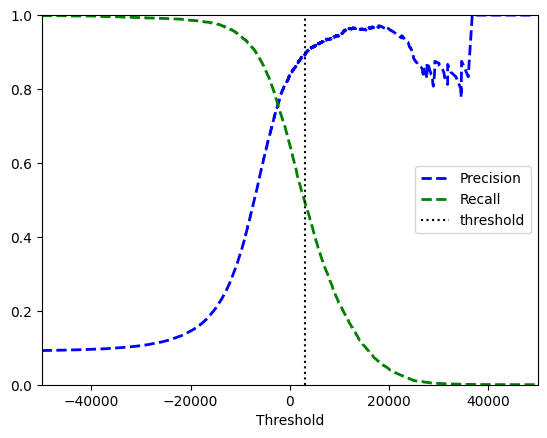

In [22]:
#plot precision + recall against threshold value
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

plt.axis([-50000, 50000, 0, 1])
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

The precision curve is bumpier because precision is more sensitive to false positives that fluctuate when the threshold changes.

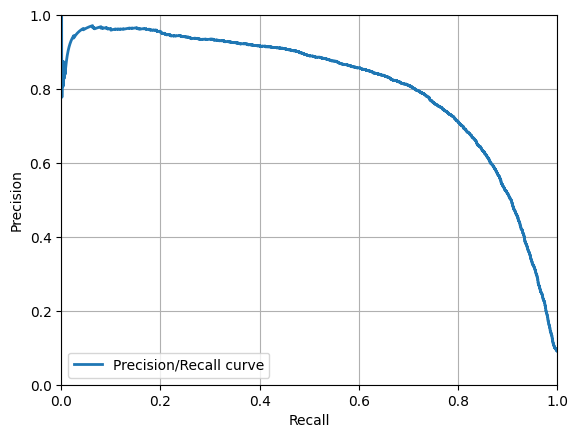

In [23]:
#another way to select a good precision/recall trade-off is to plot precision directly against recall
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

#we can see precision falls sharply after 80%.

In [24]:
#finding the lowest threshold that gives us 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision =thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [25]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.9000345901072293


0.4799852425751706

In [26]:
#the ROC curve plots TPR against FPR.
#FPR = 1 - TNR(specificity)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

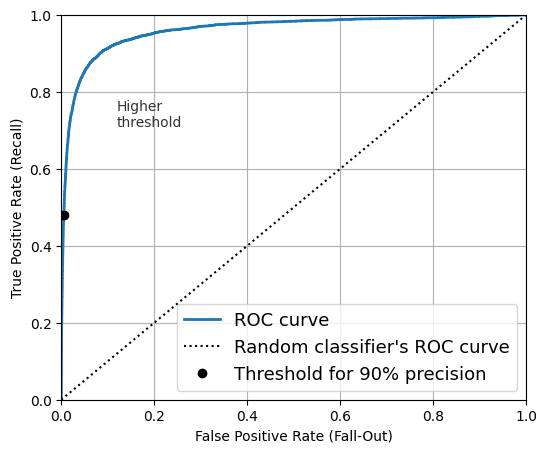

In [27]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

a good classifier model stays far away from the random classifier, like our model is doing at the top left corner. but there is room for improvement that the ROC curve is not showing us. In the previous precision-recall curve, the curve could be closer to the top right.

In [28]:
#AUC (area under the curve) - can be used to compare classifiers. AUC = 1 is a perfect classifier, AUC = 0.5 is a random classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [30]:
#random forest doesn't have a way to directly get decision functions, so we can use
#predict_proba() instead. we can use the probability of the pos class as a score.
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [31]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [32]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

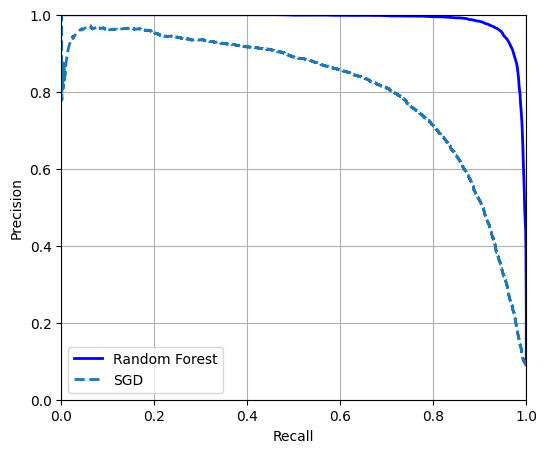

In [33]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

random forest performs better than SGD. We can see its curve is far closer to the top right corner.

In [34]:
#this better performance is also confirmed by f1 and roc auc scores.
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f'f1 score: {f1_score(y_train_5, y_train_pred_forest)}')
print(f'roc_auc score: {roc_auc_score(y_train_5, y_scores_forest)}')
print(f'precision score: {precision_score(y_train_5, y_train_pred_forest)}')
print(f'recall score: {precision_score(y_train_5, y_train_pred_forest)}')


f1 score: 0.9274509803921569
roc_auc score: 0.9983436731328145
precision score: 0.9897468089558485
recall score: 0.9897468089558485


**Multiclass Classification**

In [35]:
from sklearn.svm import SVC #scikit learn detects when you're using a binary classifier
#for multiclass classification and switches automatically

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [36]:
svm_clf.predict([some_digit]) #correct prediction

array([5], dtype=uint8)

In [37]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [38]:
class_id = some_digit_scores.argmax() #the highest score corresponds to 5
class_id

np.int64(5)

In [39]:
#looking up class labels
print(svm_clf.classes_)
svm_clf.classes_[class_id]

[0 1 2 3 4 5 6 7 8 9]


np.uint8(5)

In [40]:
from sklearn.multiclass import OneVsRestClassifier #create a multiclass classifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [41]:
#prediction
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
#checking # of trained classifiers
len(ovr_clf.estimators_)


10

In [43]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2) #highest score is 9.3 from class 5

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [45]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [46]:
print(svm_clf.classes_) #classes_ stores the list of target classes in order of value
print(svm_clf.classes_[class_id])

[0 1 2 3 4 5 6 7 8 9]
5


In [47]:
from sklearn.multiclass import OneVsRestClassifier #directly using OvR

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [48]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) #prediction mistakes can happen. Here, SGD predicted a 3 instead of a 5.

array([3], dtype=uint8)

In [49]:
sgd_clf.decision_function([some_digit]).round() #negative scores

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [51]:
#we can improve the accuracy by scaling the inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

**Error Analysis**

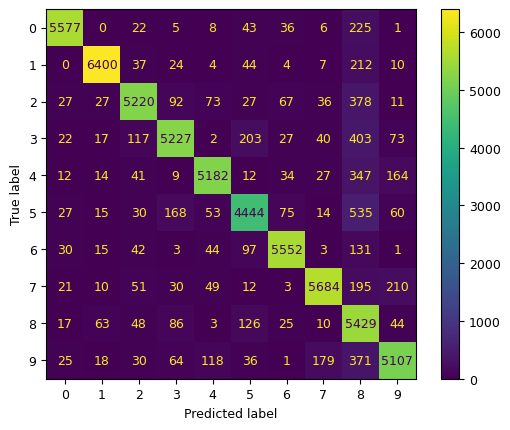

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

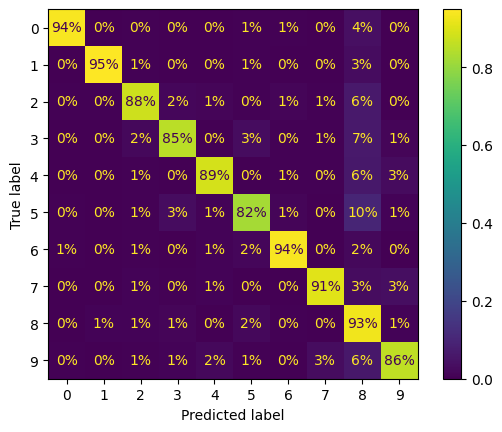

In [54]:
#normalized confusion matrix. we set normalize to true.
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

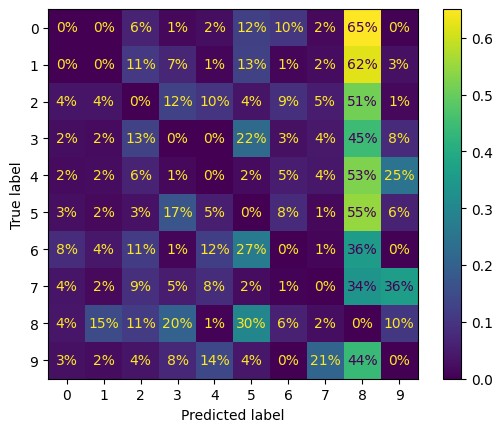

In [55]:
#confusion matrix with errors only. we can see that many images were misclassified as 8s.
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

In [56]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
#plotting these images in a confusion matrix style

**Multilabel classification**

In [58]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [60]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [61]:
#evaluate multilabel classifier using f1 scores
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [62]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [63]:
chain_clf.predict([some_digit])

array([[0., 1.]])

**Multioutput classification**

In [64]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

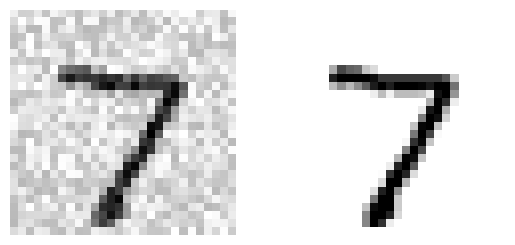

In [65]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

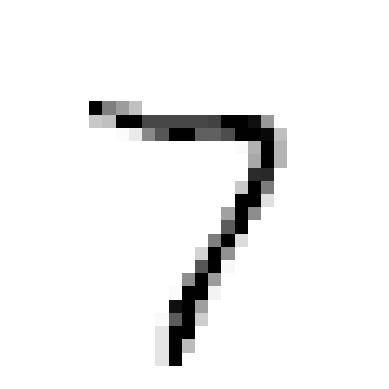

In [66]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()